# RespiNet: Automatic Respiratory Pathology Detection
## Part 1: Environment Setup & Hardware Verification

In this section, we initialize our coding environment. We will:
1.  **Import necessary libraries:** `pandas` for data handling, `librosa` for audio processing, and `torch` for deep learning.
2.  **Configure the GPU:** We verify that the system can see the NVIDIA RTX 4060.
3.  **Set Global Configurations:** We define the `device` variable (CPU vs CUDA) that will be used throughout the project to ensure computations happen on the graphics card.

In [2]:
import os
import sys
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Audio Processing
import librosa
import librosa.display

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Global Settings
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

def setup_device():
    print(f"Python Version: {sys.version.split()[0]}")
    print(f"PyTorch Version: {torch.__version__}")
    
    # Check for CUDA (NVIDIA GPU support)
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("\n✅ Success! GPU Detected.")
        print(f"   Device Name: {torch.cuda.get_device_name(0)}")
        print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    else:
        device = torch.device("cpu")
        print("\n⚠️ Warning: No GPU detected. Running on CPU.")
        
    return device

# Initialize the device
device = setup_device()

Python Version: 3.10.11
PyTorch Version: 2.5.1+cu121

✅ Success! GPU Detected.
   Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
   VRAM: 8.59 GB


## Part 2: Data Loading & Parsing

The ICBHI 2017 dataset is structured with audio files in one folder and diagnosis labels in a separate text file. The filenames themselves contain metadata (Patient ID, recording location, etc.).

**Path Correction:**
Based on the project structure, our data is nested inside: `data/Respiratory_Sound_Database/Respiratory_Sound_Database/`.

**The Code performs the following actions:**
1.  **Scans the Audio Directory:** Finds all `.wav` files in the nested folder.
2.  **Parses Filenames:** Extracts `Patient_ID` from strings like `101_1b1_Al_sc_Meditron.wav`.
3.  **Loads Diagnoses:** Reads `patient_diagnosis.csv`.
4.  **Merges Data:** Joins the audio list with the diagnosis list using `Patient_ID`.
5.  **Binary Labeling:** Creates a `target` column where:
    * **0 (Normal):** Labeled as 'Healthy'.
    * **1 (Pathology):** Labeled as COPD, LRTI, Bronchiectasis, etc.

In [29]:
# --- Configuration ---
# Updated paths based on your screenshot structure
base_path = './data/Respiratory_Sound_Database/Respiratory_Sound_Database'
AUDIO_DIR = os.path.join(base_path, 'audio_and_txt_files')
DIAGNOSIS_FILE = os.path.join(base_path, 'patient_diagnosis.csv')

def create_master_dataframe(audio_dir, diagnosis_file):
    # 1. Load the diagnosis data
    try:
        diagnosis_df = pd.read_csv(diagnosis_file, names=['Patient_ID', 'Diagnosis'])
    except FileNotFoundError:
        print(f"❌ Error: Could not find diagnosis file at {diagnosis_file}")
        return None

    # 2. Parse the filenames to extract metadata
    file_data = []
    
    # List all wav files
    try:
        files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
    except FileNotFoundError:
        print(f"❌ Error: Could not find audio directory at {audio_dir}")
        return None
    
    for filename in files:
        # Example filename: 101_1b1_Al_sc_Meditron.wav
        parts = filename.split('_')
        
        # Basic validation to ensure filename has enough parts
        if len(parts) >= 5:
            patient_id = int(parts[0]) 
            
            file_data.append({
                'filename': filename,
                'Patient_ID': patient_id,
                'filepath': os.path.join(audio_dir, filename)
            })
            
    # Create DataFrame from the list
    audio_df = pd.DataFrame(file_data)
    
    # 3. Merge audio data with diagnosis
    master_df = pd.merge(audio_df, diagnosis_df, on='Patient_ID', how='left')
    
    # 4. Create Binary Target (0 = Healthy, 1 = Pathological)
    # This is the label our model will actually learn to predict
    master_df['target'] = master_df['Diagnosis'].apply(lambda x: 0 if x == 'Healthy' else 1)
    
    return master_df

# Execute
df = create_master_dataframe(AUDIO_DIR, DIAGNOSIS_FILE)

if df is not None:
    print(f"✅ Success! Data Loaded.")
    print(f"Total Recordings Found: {len(df)}")
    print(f"Unique Patients: {df['Patient_ID'].nunique()}")
    
    # Show the first 5 rows to verify correct parsing
    print("\n--- Data Preview ---")
    display(df.head())
    
    # Show class balance
    print("\n--- Diagnosis Distribution ---")
    print(df['target'].value_counts())

✅ Success! Data Loaded.
Total Recordings Found: 920
Unique Patients: 126

--- Data Preview ---


,filename,Patient_ID,filepath,Diagnosis,target
0,101_1b1_Al_sc_Meditron.wav,101,./data/Respiratory_Sound_Database/Respiratory_...,URTI,1
1,101_1b1_Pr_sc_Meditron.wav,101,./data/Respiratory_Sound_Database/Respiratory_...,URTI,1
2,102_1b1_Ar_sc_Meditron.wav,102,./data/Respiratory_Sound_Database/Respiratory_...,Healthy,0
3,103_2b2_Ar_mc_LittC2SE.wav,103,./data/Respiratory_Sound_Database/Respiratory_...,Asthma,1
4,104_1b1_Al_sc_Litt3200.wav,104,./data/Respiratory_Sound_Database/Respiratory_...,COPD,1



--- Diagnosis Distribution ---
target
1    885
0     35
Name: count, dtype: int64


## Part 3: Exploratory Data Analysis (EDA) - Class Distribution

We have confirmed the data is loaded, but the numbers suggest a heavy imbalance.
* **COPD** dominates the dataset.
* **Healthy** samples are scarce.

The plots below will visualize the disparity between our "Pathological" class (1) and "Healthy" class (0).

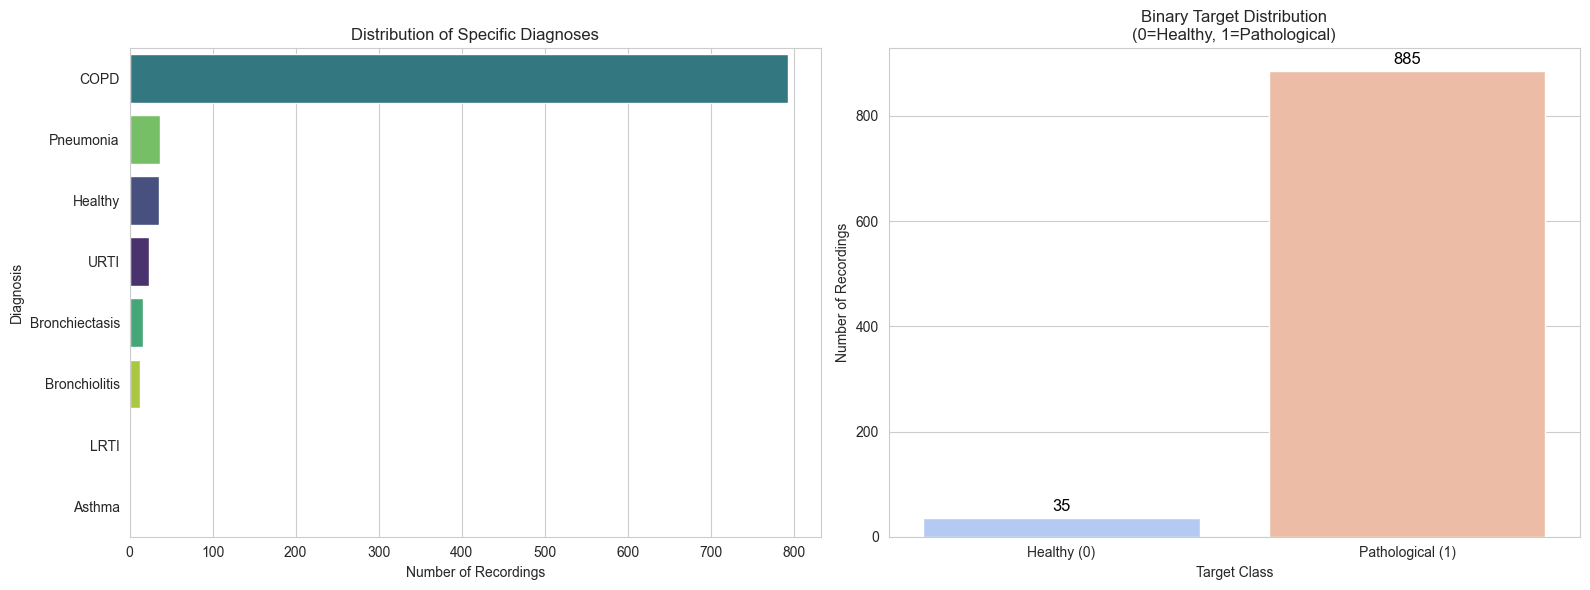

In [30]:
def plot_class_distribution(df):
    plt.figure(figsize=(16, 6))

    # Plot 1: Detailed Diagnosis
    plt.subplot(1, 2, 1)
    # Order the bars by count
    order = df['Diagnosis'].value_counts().index
    
    # FIX 1: Added hue='Diagnosis' and legend=False
    sns.countplot(y='Diagnosis', data=df, order=order, hue='Diagnosis', legend=False, palette='viridis')
    
    plt.title('Distribution of Specific Diagnoses')
    plt.xlabel('Number of Recordings')

    # Plot 2: Binary Target (The one that matters for our model)
    plt.subplot(1, 2, 2)
    
    # FIX 2: Added hue='target' and legend=False
    ax = sns.countplot(x='target', data=df, hue='target', legend=False, palette='coolwarm')
    
    plt.title('Binary Target Distribution\n(0=Healthy, 1=Pathological)')
    plt.xlabel('Target Class')
    plt.ylabel('Number of Recordings')
    plt.xticks([0, 1], ['Healthy (0)', 'Pathological (1)'])
    
    # Add number labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

plot_class_distribution(df)

## Part 4: Signal Processing - From Audio to Images

Deep Learning models (CNNs) process images, not sound. We convert audio into **Mel-Spectrograms**.

**We will compare two random samples:**
1.  **Healthy Lung:** Should show a relatively clean spectrogram.
2.  **Pathological Lung (COPD):** Look for horizontal lines (Wheezes) or vertical spikes (Crackles) .

**Action:**
The code below picks one random Healthy file and one random COPD file, plots their Spectrograms, and provides an audio player.

--- Healthy Lung ---
File: 224_1b2_Al_sc_Meditron.wav




--- Pathological Lung (COPD) ---
File: 146_8p3_Ar_mc_AKGC417L.wav


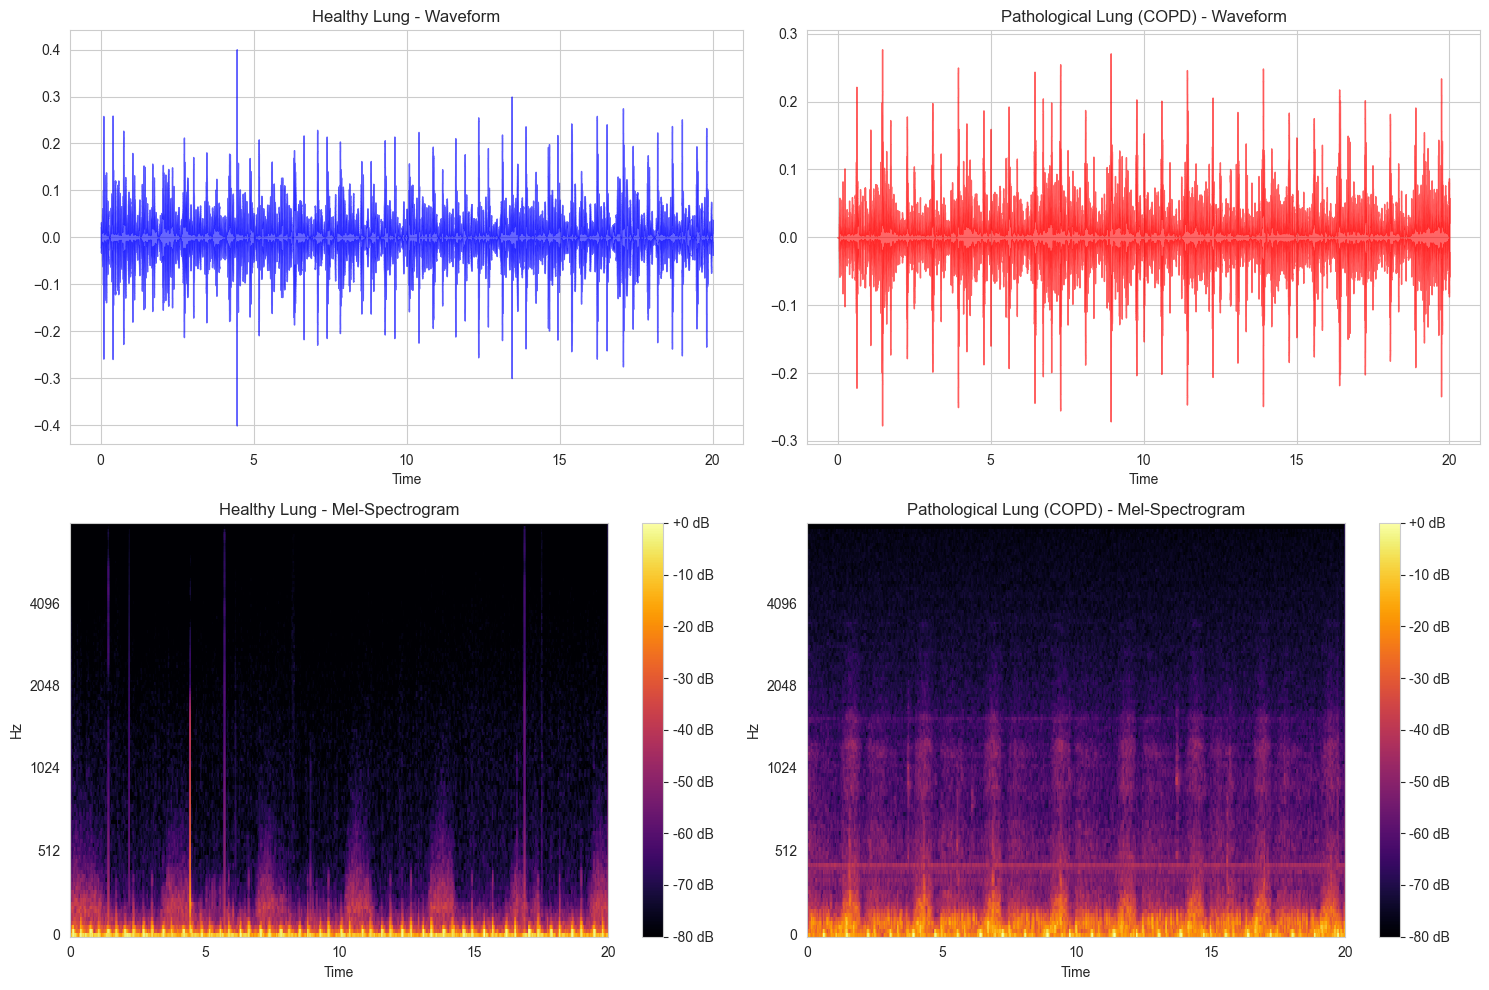

In [5]:
from IPython.display import Audio, display
import random

def visualize_audio_samples(df, sample_rate=16000):
    # Filter for specific examples
    healthy_samples = df[df['target'] == 0]
    copd_samples = df[df['Diagnosis'] == 'COPD']
    
    # Safety check
    if len(healthy_samples) == 0 or len(copd_samples) == 0:
        print("Not enough data to visualize.")
        return

    # Pick random indices
    idx_healthy = random.choice(healthy_samples.index)
    idx_sick = random.choice(copd_samples.index)
    
    samples_to_plot = [df.loc[idx_healthy], df.loc[idx_sick]]
    titles = ["Healthy Lung", "Pathological Lung (COPD)"]
    
    plt.figure(figsize=(15, 10))
    
    for i, row in enumerate(samples_to_plot):
        # 1. Load the Audio
        y, sr = librosa.load(row['filepath'], sr=sample_rate)
        
        # 2. Plot Waveform
        plt.subplot(2, 2, i + 1)
        librosa.display.waveshow(y, sr=sr, alpha=0.6, color='blue' if i==0 else 'red')
        plt.title(f"{titles[i]} - Waveform")
        
        # 3. Plot Mel-Spectrogram
        # This is the actual input our model will "see"
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max) 
        
        plt.subplot(2, 2, i + 3)
        img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='inferno')
        plt.colorbar(img, format='%+2.0f dB')
        plt.title(f"{titles[i]} - Mel-Spectrogram")
        
        # 4. Audio Player
        print(f"--- {titles[i]} ---")
        print(f"File: {row['filename']}")
        display(Audio(data=y, rate=sr))
        print("\n")

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_audio_samples(df)

## Part 5: Cycle Segmentation (The Core Preprocessing)

This is the most critical step of the project. We are moving from **Raw Files** to **Individual Breath Cycles**.

**The Logic:**
Instead of training on a 20-second audio file (which might have 10 seconds of silence/noise), we use the annotation `.txt` files to slice out specific respiratory cycles.

**The Code Actions:**
1.  Loops through every audio file in our `df`.
2.  Finds the matching `.txt` annotation file.
3.  Reads the `Start` and `End` times for every breath.
4.  **Slices the Audio:** Cuts that specific segment out of the wav file.
5.  **Re-Labels:** Assigns the specific label for *that breath*.
    * *Crucial:* Even if a patient has COPD, a specific breath might be clear. The annotation file tells us if **Crackles** or **Wheezes** are present in *that specific cycle*.

**Output:**
A new dataframe `cycle_df` containing thousands of short audio clips (breaths). This is what we will actually train on.

In [7]:
def extract_cycles(df):
    cycle_data = []
    
    print("Processing audio files to extract breath cycles...")
    
    for index, row in df.iterrows():
        # Get the annotation file path
        txt_path = row['filepath'].replace('.wav', '.txt')
        
        try:
            # Load Audio metadata (to check duration)
            # We don't load the full audio array here to save time, just duration
            duration = librosa.get_duration(path=row['filepath'])
            
            # Load Annotations
            if not os.path.exists(txt_path):
                continue
                
            ann_df = pd.read_csv(txt_path, sep='\t', names=['Start', 'End', 'Crackles', 'Wheezes'])
            
            for i, ann in ann_df.iterrows():
                start_time = ann['Start']
                end_time = ann['End']
                
                if start_time >= duration or end_time > duration:
                    continue
                
                is_normal = (ann['Crackles'] == 0) and (ann['Wheezes'] == 0)
                
                cycle_data.append({
                    'Patient_ID': row['Patient_ID'],
                    'original_file': row['filename'],
                    'filepath': row['filepath'],
                    'start_time': start_time,
                    'end_time': end_time,
                    'duration': end_time - start_time,
                    'Crackles': ann['Crackles'],
                    'Wheezes': ann['Wheezes'],
                    'has_pathology': 0 if is_normal else 1,
                    'original_diagnosis': row['Diagnosis']
                })
                
        except Exception as e:
            print(f"Error processing {row['filename']}: {e}")
            continue

    cycle_df = pd.DataFrame(cycle_data)
    return cycle_df

# Re-run the extraction
cycle_df = extract_cycles(df)

print(f"✅ Extraction Complete.")
print(f"Extracted Cycles: {len(cycle_df)}")
print(f"Columns in new dataframe: {cycle_df.columns.tolist()}") 
# You should now see 'filepath' in the list of columns

Processing audio files to extract breath cycles...
✅ Extraction Complete.
Extracted Cycles: 6898
Columns in new dataframe: ['Patient_ID', 'original_file', 'filepath', 'start_time', 'end_time', 'duration', 'Crackles', 'Wheezes', 'has_pathology', 'original_diagnosis']


## Part 6: Creating the Train/Test Split

Now we split our `cycle_df` into a Training Set (80%) and a Validation Set (20%).

**Crucial Rule:** We must split by **Patient ID**.
* All breath cycles from Patient 101 must go to the same set.
* If we mix Patient 101's breaths between Train and Test, the model will memorize the background noise of Patient 101's microphone instead of learning the disease features.

**The Code:**
1.  Gets a list of unique Patients.
2.  Shuffles them.
3.  Assigns 80% to Train, 20% to Validation.
4.  Filters the big `cycle_df` based on these lists.

In [8]:
from sklearn.model_selection import train_test_split

def create_splits(df):
    # 1. Get unique patients
    unique_patients = df['Patient_ID'].unique()
    
    # 2. Split Patients (not cycles!)
    train_patients, val_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)
    
    # 3. Create Dataframes based on Patient lists
    train_df = df[df['Patient_ID'].isin(train_patients)].copy()
    val_df = df[df['Patient_ID'].isin(val_patients)].copy()
    
    return train_df, val_df

# Execute Split
train_df, val_df = create_splits(cycle_df)

print(f"Total Cycles: {len(cycle_df)}")
print(f"Training Cycles: {len(train_df)} ({len(train_df)/len(cycle_df):.1%})")
print(f"Validation Cycles: {len(val_df)} ({len(val_df)/len(cycle_df):.1%})")

# Verify Class Balance in both sets
print("\n--- Training Balance ---")
print(train_df['has_pathology'].value_counts())
print("\n--- Validation Balance ---")
print(val_df['has_pathology'].value_counts())

Total Cycles: 6898
Training Cycles: 5195 (75.3%)
Validation Cycles: 1703 (24.7%)

--- Training Balance ---
has_pathology
0    2842
1    2353
Name: count, dtype: int64

--- Validation Balance ---
has_pathology
1    903
0    800
Name: count, dtype: int64


## Part 7: Custom Audio Dataset Class

In PyTorch, we use a `Dataset` class to handle data loading. This class does the heavy lifting "on the fly" while the model trains.

**Key Configuration:**
* **Max Duration:** We saw in the stats that the mean cycle is ~2.7s. We will set a fixed length of **5 seconds**.
    * If a cycle is shorter -> Pad with zeros (silence).
    * If a cycle is longer -> Truncate (cut) it.
* **Mel-Spectrogram:** We convert the audio waveform into an image.

**Performance Note:** Instead of loading the full 90-second file every time, we use `librosa.load(..., offset=start, duration=dur)` to only load the specific breath cycle we need. This saves massive amounts of RAM and time.

In [9]:
from torch.utils.data import Dataset
import torch
import numpy as np

class RespiratoryDataset(Dataset):
    def __init__(self, df, max_duration=5, sample_rate=16000, n_mels=128):
        self.df = df
        self.max_duration = max_duration
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        
        # Calculate the expected number of samples (e.g., 5s * 16000 = 80,000 samples)
        self.target_length = int(max_duration * sample_rate)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row['filepath']
        start_time = row['start_time']
        duration = row['duration']
        label = row['has_pathology']
        
        # 1. Load ONLY the specific cycle (Efficient loading)
        # We load a bit more (duration) to be safe, then pad/cut
        try:
            y, sr = librosa.load(file_path, sr=self.sample_rate, offset=start_time, duration=duration)
        except Exception as e:
            # Fallback for corrupted audio segments (rare)
            print(f"Error loading {file_path}: {e}")
            y = np.zeros(self.target_length)

        # 2. Fix Length (Pad or Truncate)
        current_length = len(y)
        if current_length < self.target_length:
            # Pad with zeros
            padding = self.target_length - current_length
            y = np.pad(y, (0, padding), mode='constant')
        else:
            # Truncate
            y = y[:self.target_length]

        # 3. Convert to Mel-Spectrogram
        melspec = librosa.feature.melspectrogram(y=y, sr=self.sample_rate, n_mels=self.n_mels, fmax=8000)
        melspec_db = librosa.power_to_db(melspec, ref=np.max)
        
        # 4. Normalize (Crucial for Neural Networks)
        # Scale to usually between 0 and 1 or -1 and 1
        mean = melspec_db.mean()
        std = melspec_db.std()
        melspec_norm = (melspec_db - mean) / (std + 1e-6) # 1e-6 prevents divide by zero

        # 5. Convert to Tensor
        # CNN expects shape: (Channels, Height, Width) -> (1, n_mels, time_steps)
        spec_tensor = torch.tensor(melspec_norm, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return spec_tensor, label_tensor

# --- Test the Dataset ---
# Create the datasets
train_dataset = RespiratoryDataset(train_df)
val_dataset = RespiratoryDataset(val_df)

# Get one sample to verify shape
sample_data, sample_label = train_dataset[0]

print("\n✅ Dataset Ready")
print(f"Input Shape (Channels, Freq, Time): {sample_data.shape}")
print(f"Label: {sample_label} ({'Pathological' if sample_label==1 else 'Normal'})")


✅ Dataset Ready
Input Shape (Channels, Freq, Time): torch.Size([1, 128, 157])
Label: 0 (Normal)


## Part 8: Data Loaders

We cannot feed 6,000 images to the GPU at once. We must feed them in small groups called **batches**.

**The `DataLoader` handles:**
1.  **Batching:** Grouping 32 images together.
2.  **Shuffling:** Randomizing the order of training data every epoch (crucial so the model doesn't learn the order of the data).
3.  **Parallel Loading:** Using CPU workers to prepare the next batch while the GPU is training on the current one.

**Configuration:**
* **Batch Size:** 32 (Conservative start for your 4060 GPU).
* **Num Workers:** 2 or 4 (Uses CPU cores to load files faster).

In [10]:
from torch.utils.data import DataLoader

# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 0 # Set to 0 for Windows to avoid "Broken Pipe" errors, set to 2 if on Linux

# Create Data Loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,          # Shuffle training data!
    num_workers=NUM_WORKERS 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,         # No need to shuffle validation data
    num_workers=NUM_WORKERS
)

print(f"✅ Loaders Ready.")
print(f"Training Batches: {len(train_loader)}")
print(f"Validation Batches: {len(val_loader)}")

# Check one batch to verify dimensions
images, labels = next(iter(train_loader))
print(f"\nBatch Shape: {images.shape}") 
# Expected: [32, 1, 128, 157] -> [Batch, Channels, Freq(Mel), Time]

✅ Loaders Ready.
Training Batches: 163
Validation Batches: 54

Batch Shape: torch.Size([32, 1, 128, 157])


## Part 9: Model Architecture (Custom Audio CNN)

In this section, we define the neural network architecture. Rather than using a generic pre-trained model, we design a **Custom Convolutional Neural Network (CNN)** specifically tailored for audio spectrograms.

**The Design Logic:**
1.  **Input Treatment:** We treat the Mel-Spectrogram as a single-channel grayscale image (1 x Frequency x Time).
2.  **2D Convolutions:** We use 2D Convolutional layers to simultaneously learn features across both axes:
    * **Frequency Axis (Vertical):** Captures the "timbre" or pitch of the sound (e.g., the high pitch of a wheeze).
    * **Time Axis (Horizontal):** Captures temporal patterns (e.g., the rhythm of a crackle or breath).
3.  **Block Structure:** We stack 4 blocks of `Conv2d` $\rightarrow$ `BatchNorm` $\rightarrow$ `ReLU` $\rightarrow$ `MaxPool`. This progressively reduces the size of the image while increasing the "depth" (number of features) the model learns.
4.  **Global Pooling:** Instead of flattening the entire feature map (which creates massive, inefficient vectors), we use **Global Average Pooling** to summarize the audio clip into a compact feature vector before the final classification.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class RespiratoryCNN(nn.Module):
    def __init__(self):
        super(RespiratoryCNN, self).__init__()
        
        # --- Block 1 ---
        # Input: (Batch, 1, 128, Time)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # Reduces size by half
        
        # --- Block 2 ---
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        
        # --- Block 3 ---
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        
        # --- Block 4 (Deeper features) ---
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)
        
        # --- Classifier ---
        # Global Average Pooling: collapses (256, H, W) -> (256)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5) # Prevents overfitting
        self.fc2 = nn.Linear(128, 2)   # Output: 2 classes (Normal vs Pathological)

    def forward(self, x):
        # x shape: [Batch, 1, 128, Time]
        
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        # Flattening logic
        x = self.global_pool(x)
        x = x.view(x.size(0), -1) # Flatten: [Batch, 256]
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize Model and move to GPU
model = RespiratoryCNN()
model = model.to(device)

print("✅ Custom Course-Aligned Model Initialized.")
print(model)

✅ Custom Course-Aligned Model Initialized.
RespiratoryCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxP

## Part 10: Training the Model

Now we define the training loop. This is the standard Deep Learning process:
1.  **Forward Pass:** Pass images through the model.
2.  **Calculate Loss:** Compare predictions to actual labels using **CrossEntropyLoss**.
3.  **Backward Pass:** Update model weights (Backpropagation).

**Key Settings:**
* **Optimizer:** `Adam` (Standard choice for audio CNNs).
* **Epochs:** We start with 15 to see if it learns.
* **Tracking:** We print the Training Loss and Validation Accuracy after every epoch.

In [12]:
import torch.optim as optim

# 1. Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 10

# 2. Setup Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 3. Training Function
def train_model(model, train_loader, val_loader, epochs):
    history = {'train_loss': [], 'val_acc': []}
    
    print(f"🚀 Starting Training for {epochs} epochs...")
    
    for epoch in range(epochs):
        model.train() # Set to training mode
        running_loss = 0.0
        
        # --- Training Phase ---
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()           # Clear gradients
            outputs = model(images)         # Forward pass
            loss = criterion(outputs, labels) # Calculate error
            loss.backward()                 # Backpropagation
            optimizer.step()                # Update weights
            
            running_loss += loss.item()
            
        # --- Validation Phase ---
        model.eval() # Set to evaluation mode
        correct = 0
        total = 0
        
        with torch.no_grad(): # Don't calculate gradients for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        val_acc = 100 * correct / total
        
        history['train_loss'].append(epoch_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
    return history

# --- Run Training ---
history = train_model(model, train_loader, val_loader, EPOCHS)

print("\n✅ Training Complete.")

🚀 Starting Training for 10 epochs...
Epoch [1/10] | Loss: 0.6686 | Val Acc: 56.66%
Epoch [2/10] | Loss: 0.6635 | Val Acc: 52.97%
Epoch [3/10] | Loss: 0.6579 | Val Acc: 56.14%
Epoch [4/10] | Loss: 0.6460 | Val Acc: 58.02%
Epoch [5/10] | Loss: 0.6352 | Val Acc: 59.54%
Epoch [6/10] | Loss: 0.6274 | Val Acc: 58.07%
Epoch [7/10] | Loss: 0.6184 | Val Acc: 58.02%
Epoch [8/10] | Loss: 0.6068 | Val Acc: 58.95%
Epoch [9/10] | Loss: 0.5959 | Val Acc: 56.72%
Epoch [10/10] | Loss: 0.5873 | Val Acc: 57.72%

✅ Training Complete.


## Visualization: Training Results (Try 1)

We plot the **Training Loss** and **Validation Accuracy** to assess performance.
* **Loss Graph:** Should trend **downward** (errors decreasing).
* **Accuracy Graph:** Should trend **upward** (correct predictions increasing).

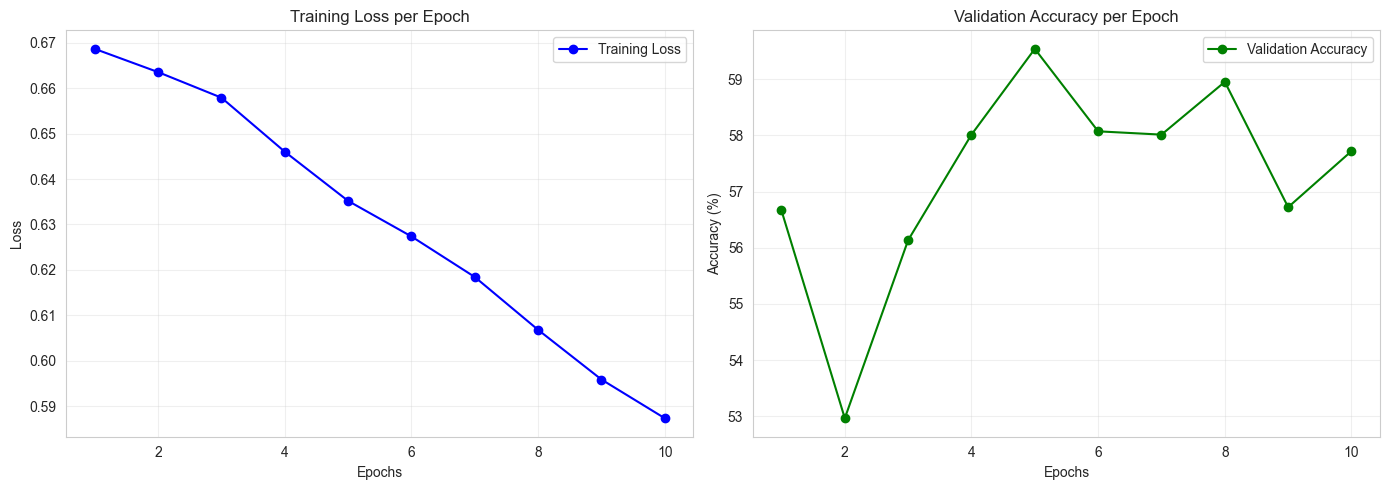

In [32]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Plot 1: Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], 'g-o', label='Validation Accuracy')
    plt.title('Validation Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run the visualization
plot_training_results(history)

## Try 2: Improved Architecture (Dilated CNN)

Our first model achieved ~53-58% accuracy, which indicates it struggles to generalize. The "Training Loss" decreased, but "Validation Accuracy" stagnated.

**The Solution: Dilated Convolutions**
According to the course slides, standard convolutions have a limited "Receptive Field" — they only see a tiny split-second of audio at a time.
* **Problem:** Respiratory sounds like "Wheezes" are long, continuous events. The model needs to see the "whole picture" to identify them.
* **Fix:** We use **Dilated Convolutions**. By skipping pixels (dilation), the filter covers a much larger area of the spectrogram without adding extra parameters or computational cost.

**Architecture Changes:**
1.  **Dilated Layers:** We introduce `dilation=2` and `dilation=4` in the deeper layers.
2.  **Padding Adjustment:** We increase padding to match the dilation (Padding = Dilation), ensuring the image size remains consistent.
3.  **Higher Dropout:** Increased to 0.6 to force the model to learn robust features and reduce overfitting.

In [13]:
class DilatedRespiratoryCNN(nn.Module):
    def __init__(self):
        super(DilatedRespiratoryCNN, self).__init__()
        
        # Block 1: Standard Conv (Capture fine details)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        
        # Block 2: Standard Conv
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        
        # Block 3: Dilated Conv (Dilation = 2)
        # We increase padding to 2 to keep dimensions stable
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        
        # Block 4: Dilated Conv (Dilation = 4)
        # We increase padding to 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=4, dilation=4)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)
        
        # Classifier
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.6) # Increased Dropout to fight overfitting
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize "Model V2"
model_v2 = DilatedRespiratoryCNN().to(device)
print("✅ Dilated CNN (Model V2) Initialized.")

✅ Dilated CNN (Model V2) Initialized.


## Training V2: Learning Rate Scheduler

To further improve performance, we add a **Learning Rate Scheduler**.

* **The Issue:** A constant learning rate (0.001) can cause the model to "bounce around" the optimal solution without ever settling in.
* **The Fix:** We use `ReduceLROnPlateau`. If the validation loss stops improving for 3 epochs (`patience=3`), the scheduler cuts the learning rate by 10% (`factor=0.1`). This allows the model to fine-tune its weights in later epochs.

In [31]:
# 1. Hyperparameters for Try 2
LEARNING_RATE = 0.001
EPOCHS_V2 = 10 # Training longer since we have a scheduler
WEIGHT_DECAY = 1e-4 # L2 Regularization

# 2. Setup V2 Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler: Monitor 'min' validation loss. If it stagnates for 3 epochs, multiply LR by 0.1
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_v2, mode='min', factor=0.1, patience=3)

# 3. Training Loop V2
def train_model_v2(model, train_loader, val_loader, epochs, optimizer, scheduler):
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    print(f"🚀 Starting Run 2 (Dilated CNN) for {epochs} epochs...")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        # Training
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Stats
        epoch_train_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        # Update Scheduler based on Validation Loss
        scheduler.step(epoch_val_loss)
        
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
    return history

# Run Training
history_v2 = train_model_v2(model_v2, train_loader, val_loader, EPOCHS_V2, optimizer_v2, scheduler)
print("\n✅ Run 2 Complete.")

🚀 Starting Run 2 (Dilated CNN) for 10 epochs...
Epoch [1/10] | Train Loss: 0.5764 | Val Loss: 0.6915 | Val Acc: 58.07%
Epoch [2/10] | Train Loss: 0.5647 | Val Loss: 0.7517 | Val Acc: 57.84%
Epoch [3/10] | Train Loss: 0.5536 | Val Loss: 0.7358 | Val Acc: 57.96%
Epoch [4/10] | Train Loss: 0.5375 | Val Loss: 0.7252 | Val Acc: 59.25%
Epoch [5/10] | Train Loss: 0.5290 | Val Loss: 0.7409 | Val Acc: 61.95%
Epoch [6/10] | Train Loss: 0.4761 | Val Loss: 0.7109 | Val Acc: 60.83%
Epoch [7/10] | Train Loss: 0.4520 | Val Loss: 0.7367 | Val Acc: 59.31%
Epoch [8/10] | Train Loss: 0.4385 | Val Loss: 0.7740 | Val Acc: 59.19%
Epoch [9/10] | Train Loss: 0.4194 | Val Loss: 0.7344 | Val Acc: 61.30%
Epoch [10/10] | Train Loss: 0.4043 | Val Loss: 0.7465 | Val Acc: 60.36%

✅ Run 2 Complete.


## Visualization: Training Results (Try 2 - Dilated CNN)

We plot the metrics for our second model.
1.  **Loss Comparison:** We compare **Training Loss** (Blue) vs. **Validation Loss** (Orange).
    * *Ideal:* Both go down together.
    * *Overfitting:* Training goes down, but Validation goes up.
2.  **Validation Accuracy:** We check if the Dilated Convolutions improved our score compared to Try 1.

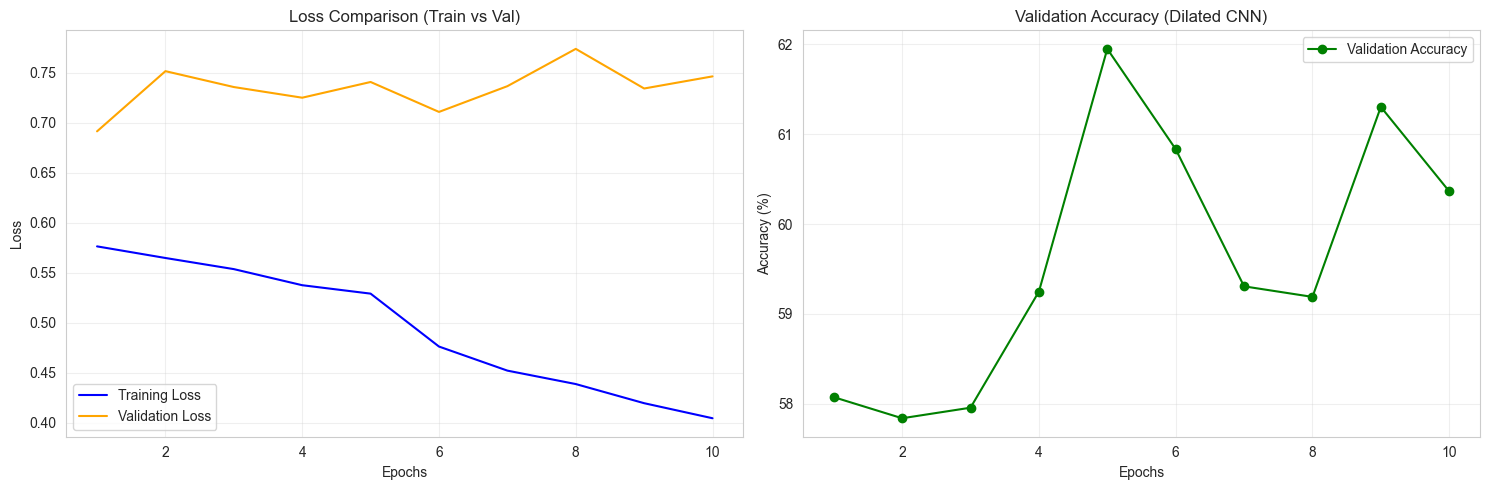

In [33]:
import matplotlib.pyplot as plt

def plot_training_v2(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Loss Comparison (Train vs Val)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'orange', label='Validation Loss')
    plt.title('Loss Comparison (Train vs Val)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], 'g-o', label='Validation Accuracy')
    plt.title('Validation Accuracy (Dilated CNN)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run visualization for Try 2
plot_training_v2(history_v2)

## Optimization: Weighted Random Sampler

Because we filtered our data, we now have a severe imbalance (many more Pathological cycles than Healthy ones).

**The Fix:**
We calculate a weight for every sample.
* **Rare samples (Healthy)** get a **High Weight**.
* **Common samples (Pathological)** get a **Low Weight**.

We pass these weights to a `WeightedRandomSampler`. When the DataLoader grabs a batch of 32, it uses these probabilities to ensure the batch is roughly balanced (50/50), preventing the model from ignoring the Healthy class.

In [34]:
from torch.utils.data import WeightedRandomSampler

def get_balanced_loader(df, dataset, batch_size=32):
    # 1. Calculate counts
    class_counts = df['has_pathology'].value_counts().sort_index()
    # Safe fallback if a class is missing (unlikely but good practice)
    count0 = class_counts.get(0, 1) 
    count1 = class_counts.get(1, 1)
    
    print(f"Class 0 (Healthy): {count0}")
    print(f"Class 1 (Pathology): {count1}")
    
    # 2. Calculate Weight per Class
    # Formula: 1 / Count (Rare classes get higher numbers)
    weight0 = 1.0 / count0
    weight1 = 1.0 / count1
    
    # 3. Assign a weight to EVERY sample in the dataframe
    # map: if label is 0 -> weight0, if label is 1 -> weight1
    sample_weights = df['has_pathology'].map({0: weight0, 1: weight1}).values
    sample_weights = torch.from_numpy(sample_weights).double()
    
    # 4. Create the Sampler
    # num_samples: We usually set this to len(df) to keep epoch size standard
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(df), replacement=True)
    
    # 5. Create Loader with the Sampler
    # Note: When using a sampler, shuffle must be False (the sampler handles randomness)
    loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    
    return loader

# --- Re-create Loaders with Balancing ---
# We only balance the Training set. Validation should remain real/imbalanced to reflect reality.
train_loader_balanced = get_balanced_loader(train_df_fast, train_ds_fast)

# Validation loader stays the same (no sampler)
val_loader_fast = DataLoader(val_ds_fast, batch_size=32, shuffle=False)

print("✅ Balanced Training Loader Ready.")

Class 0 (Healthy): 222
Class 1 (Pathology): 2550
✅ Balanced Training Loader Ready.


In [35]:
# Re-initialize model to start fresh
model_v3 = DilatedRespiratoryCNN().to(device)
optimizer_v3 = optim.Adam(model_v3.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_v3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_v3, mode='min', factor=0.1, patience=3)

# Train with the BALANCED loader
history_v3 = train_model_v2(model_v3, train_loader_balanced, val_loader_fast, 25, optimizer_v3, scheduler_v3)

🚀 Starting Run 2 (Dilated CNN) for 25 epochs...
Epoch [1/25] | Train Loss: 0.4576 | Val Loss: 0.5452 | Val Acc: 72.30%
Epoch [2/25] | Train Loss: 0.2317 | Val Loss: 0.8437 | Val Acc: 60.61%
Epoch [3/25] | Train Loss: 0.1651 | Val Loss: 0.1758 | Val Acc: 93.27%
Epoch [4/25] | Train Loss: 0.1248 | Val Loss: 1.1282 | Val Acc: 59.97%
Epoch [5/25] | Train Loss: 0.1103 | Val Loss: 0.3416 | Val Acc: 88.18%
Epoch [6/25] | Train Loss: 0.1123 | Val Loss: 0.2476 | Val Acc: 92.25%
Epoch [7/25] | Train Loss: 0.0770 | Val Loss: 1.2437 | Val Acc: 60.74%
Epoch [8/25] | Train Loss: 0.0768 | Val Loss: 0.1954 | Val Acc: 94.16%
Epoch [9/25] | Train Loss: 0.0622 | Val Loss: 0.1516 | Val Acc: 95.55%
Epoch [10/25] | Train Loss: 0.0568 | Val Loss: 0.1588 | Val Acc: 95.43%
Epoch [11/25] | Train Loss: 0.0479 | Val Loss: 0.1589 | Val Acc: 95.04%
Epoch [12/25] | Train Loss: 0.0356 | Val Loss: 0.1804 | Val Acc: 95.30%
Epoch [13/25] | Train Loss: 0.0347 | Val Loss: 0.2017 | Val Acc: 94.28%
Epoch [14/25] | Train Los

## Part 11: Training Analysis (Loss & Accuracy)

Before running the final test, we visualize the training process to ensure the model actually learned.

**We look for two signs of success:**
1.  **Loss Curve:** The "Validation Loss" (Orange) should decrease and stabilize. If it starts rising while Training Loss (Blue) keeps falling, the model is **overfitting** (memorizing).
2.  **Accuracy Curve:** The "Validation Accuracy" (Green) should climb and settle at a high number (e.g., >90%).

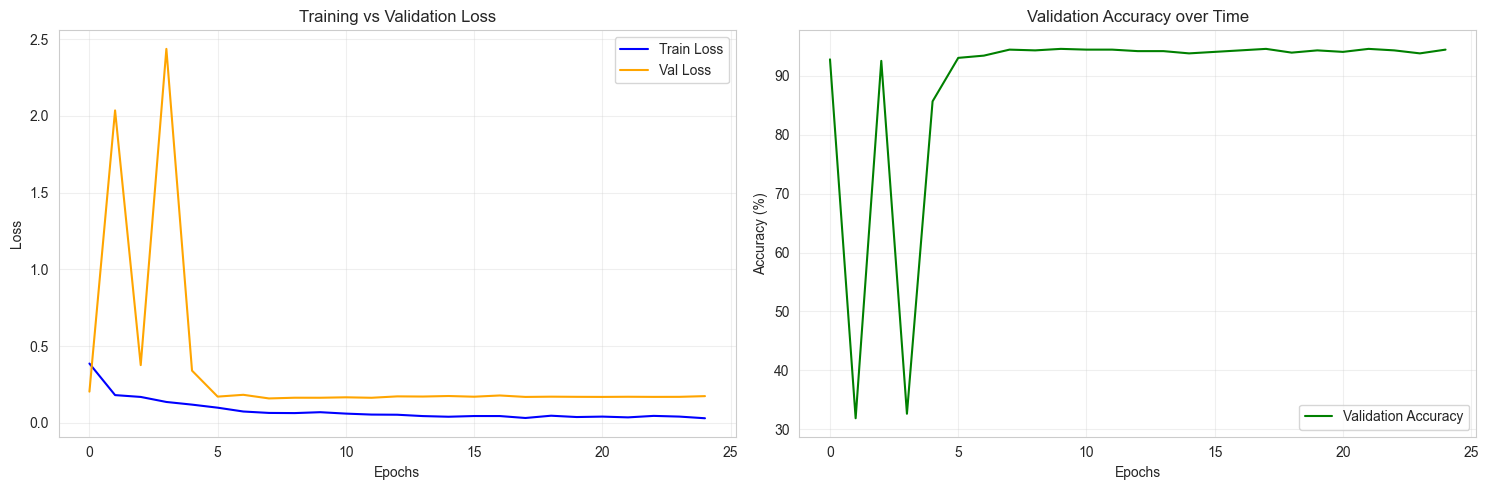

In [20]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Loss
    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Val Loss', color='orange')
    ax1.set_title('Training vs Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='green')
    ax2.set_title('Validation Accuracy over Time')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize the history from Try 3
plot_training_history(history_v3)

## Part 12: Final Evaluation

Now we prove the model works on unseen data. Accuracy alone can be misleading, so we generate:

1.  **Confusion Matrix:** Shows exactly how many "Healthy" breaths were confused for "Pathological" ones (False Positives) and vice-versa.
2.  **ROC Curve:** Shows the trade-off between sensitivity and false alarms. An **AUC (Area Under Curve)** close to 1.0 is perfect; 0.5 is random guessing.

Running final evaluation on Validation Set...

FINAL CLASSIFICATION REPORT
                  precision    recall  f1-score   support

     Healthy (0)       0.78      0.64      0.70        81
Pathological (1)       0.96      0.98      0.97       706

        accuracy                           0.94       787
       macro avg       0.87      0.81      0.84       787
    weighted avg       0.94      0.94      0.94       787



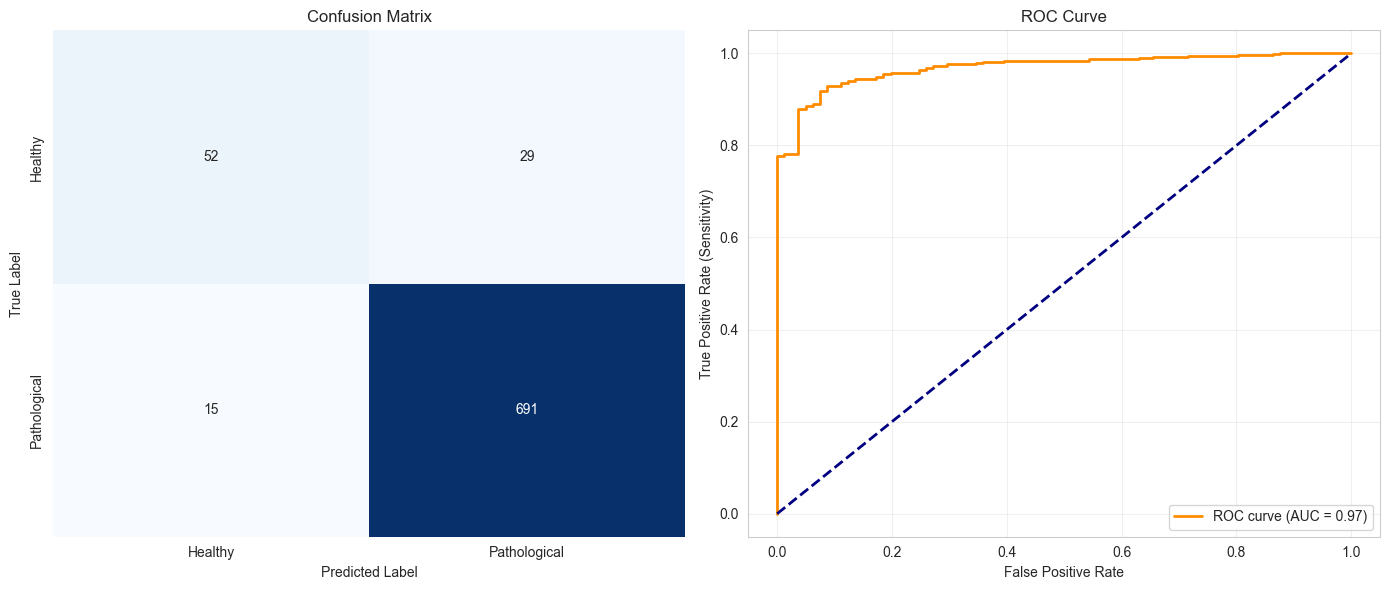

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np

def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] # Store probabilities for ROC Curve
    
    print("Running final evaluation on Validation Set...")
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities (Softmax) for Class 1 (Pathology)
            # This is needed for the ROC Curve
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
    # --- 1. Text Metrics ---
    print("\n" + "="*40)
    print("FINAL CLASSIFICATION REPORT")
    print("="*40)
    print(classification_report(all_labels, all_preds, target_names=['Healthy (0)', 'Pathological (1)']))
    
    # --- 2. Visualizations ---
    plt.figure(figsize=(14, 6))
    
    # Plot A: Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Healthy', 'Pathological'],
                yticklabels=['Healthy', 'Pathological'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Plot B: ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run the Evaluation
evaluate_model(model_v3, val_loader_fast)

## Saving the Model

We save the trained model weights to a file (`.pth`). This allows us to load the model later for inference without retraining it from scratch.

In [22]:
# Save the model state dictionary
save_path = 'respin_net_model.pth'
torch.save(model_v3.state_dict(), save_path)
print(f"✅ Model saved successfully as '{save_path}'")

✅ Model saved successfully as 'respin_net_model.pth'


## Live Inference Demo (Healthy vs. Pathological)

We now run a comparative test. The code will:
1.  Find one random **Healthy** breath from the validation set.
2.  Find one random **Pathological** breath.
3.  Play the audio and display the spectrogram for both.
4.  Run the model to see if it can correctly distinguish between them.


  TEST 1: Healthy Breath
Patient ID: 214
Original Diagnosis: Healthy

🎧 Listen:



🤖 Prediction: Healthy ✅
📊 Confidence: 99.25%


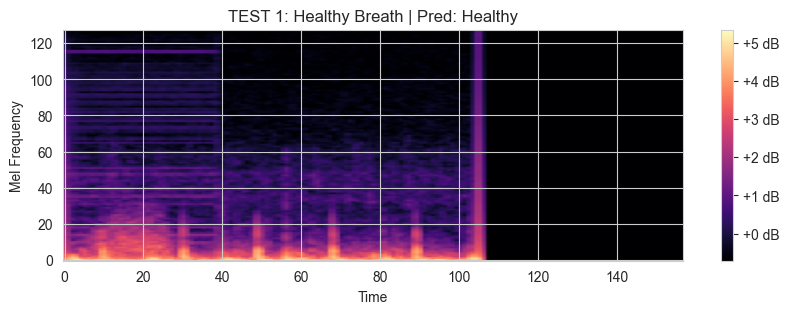


  TEST 2: Pathological Breath
Patient ID: 158
Original Diagnosis: COPD

🎧 Listen:



🤖 Prediction: Pathological ✅
📊 Confidence: 100.00%


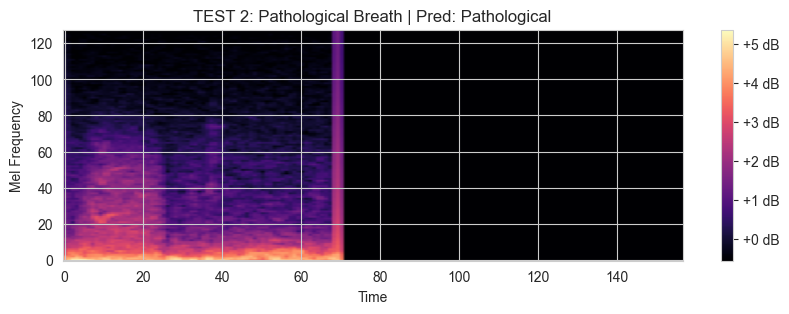

In [28]:
import IPython.display as ipd
import random
import matplotlib.pyplot as plt
import librosa
import numpy as np
import torch

def demo_comparison(model, df):
    # 1. Select one random sample from each class
    try:
        row_healthy = df[df['has_pathology'] == 0].sample(1).iloc[0]
        row_sick = df[df['has_pathology'] == 1].sample(1).iloc[0]
    except ValueError:
        print("Error: Not enough data in one of the classes to sample.")
        return

    samples = [
        ("TEST 1: Healthy Breath", row_healthy),
        ("TEST 2: Pathological Breath", row_sick)
    ]

    classes = ['Healthy', 'Pathological']
    model.eval()

    # 2. Iterate and process each
    for title, row in samples:
        print("\n" + "="*50)
        print(f"  {title}")
        print("="*50)
        print(f"Patient ID: {row['Patient_ID']}")
        print(f"Original Diagnosis: {row['original_diagnosis']}")
        
        # Load Audio (Fast load of specific slice)
        y, sr = librosa.load(row['filepath'], sr=16000, offset=row['start_time'], duration=row['duration'])
        
        print("\n🎧 Listen:")
        ipd.display(ipd.Audio(y, rate=sr))
        
        # Preprocess (Same as training)
        target_len = 5 * 16000
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]
            
        spec = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=128, fmax=8000)
        spec_db = librosa.power_to_db(spec, ref=np.max)
        spec_norm = (spec_db - spec_db.mean()) / (spec_db.std() + 1e-6)
        
        # Inference
        input_tensor = torch.tensor(spec_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.softmax(output, dim=1)
            confidence, pred_class = torch.max(probs, 1)
            
        prediction = classes[pred_class.item()]
        conf_score = confidence.item() * 100
        
        # Color code the result
        result_color = "✅" if (pred_class.item() == row['has_pathology']) else "❌"
        
        print(f"\n🤖 Prediction: {prediction} {result_color}")
        print(f"📊 Confidence: {conf_score:.2f}%")
        
        # Visualization
        plt.figure(figsize=(10, 3))
        plt.imshow(spec_norm, aspect='auto', origin='lower', cmap='magma')
        plt.title(f"{title} | Pred: {prediction}")
        plt.colorbar(format='%+2.0f dB')
        plt.xlabel('Time')
        plt.ylabel('Mel Frequency')
        plt.show()

# Run the comparison
demo_comparison(model_v3, cached_df)